# Carregando Pacotes

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pathlib import Path
import os
from matplotlib import pyplot as plt
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

2022-06-19 20:22:03.402659: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print(tf.__version__)

2.4.1


# Parâmetros

In [3]:
# Tamanho imagem
img_rows, img_cols = 600, 600

input_shape = (img_rows, img_cols, 3)

# Batch size

batch_size = 32

# seed
seed = 42

path_dataset = Path('/scratch/dpfurtado/backup_home/corais/1_classificacao_train_50/dataset/1_train_50')
path_test = path_dataset/'test_1_2'

# Carregando Base de Dados

In [4]:
test_dataset = image_dataset_from_directory(
        path_test,
        image_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=False)

Found 168 files belonging to 7 classes.


2022-06-19 20:22:06.728385: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-19 20:22:06.730553: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-19 20:22:07.614575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA GeForce GTX TITAN Black computeCapability: 3.5
coreClock: 0.98GHz coreCount: 15 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 312.92GiB/s
2022-06-19 20:22:07.615236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA GeForce GTX TITAN Black computeCapability: 3.5
coreClock: 0.98GHz coreCount: 15 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 312.92GiB/s
2022-06-19 20:22:07.615276: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcu

In [5]:
# Index para classe 
classes = test_dataset.class_names #Essa função e .file_paths não podem ser usados após o prefetch
classes_dict = dict(enumerate(classes)) 
print(classes_dict)

{0: 'agaricia_spp', 1: 'favia_gravida', 2: 'millepora_alcicornis', 3: 'montastraea_cavernosa', 4: 'palythoa_caribaeorum', 5: 'porites_astreoides', 6: 'siderastrea_stellata'}


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Carregando Modelo

In [7]:
path_extrator = './model/extrator_cnn/' 
path_modelo = './model/lr.joblib'

In [8]:
cnn_extrator = tf.keras.models.load_model(path_extrator)

In [9]:
cnn_extrator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 19, 19, 2560)      64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
Total params: 64,097,687
Trainable params: 63,786,960
Non-trainable params: 310,727
_________________________________________________________________


In [10]:
from joblib import load
model = load(path_modelo)

In [11]:
def model_funcion(y_test):
    caracteristica = cnn_extrator.predict(y_test)
    predicoes = model.predict_proba(caracteristica)
    return predicoes

# Analisando Classe 3

In [12]:
class_index = 2
print(classes_dict[class_index]) 

millepora_alcicornis


In [13]:
path_dir =  path_test/'millepora_alcicornis/'

In [14]:
class_dataset = test_dataset.unbatch().filter(lambda x, y: y == class_index).batch(batch_size)

In [15]:
predict_class_prob=model_funcion(class_dataset)
predict_class = np.argmax(predict_class_prob, axis=1)

2022-06-19 20:22:55.265826: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-19 20:22:55.284891: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2022-06-19 20:23:02.495062: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-19 20:23:03.648675: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-19 20:23:04.391526: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 367.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [16]:
list_index_class = np.where(predict_class == class_index)

In [17]:
print(list_index_class[0])

[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 29 30 31 32]


In [18]:
path_imgs = os.listdir(path_dir)
path_imgs.sort()

In [19]:
for img_incorrect in list_index_class[0]:
  print(path_imgs[img_incorrect])

2019-07-04_17-24-47_UTC.jpg
2019-07-19_23-19-03_UTC.jpg
2019-08-04_07-58-44_UTC.jpg
2019-09-03_22-46-09_UTC_2.jpg
2019-09-03_22-46-09_UTC_3.jpg
2019-09-03_22-46-09_UTC_7.jpg
2019-10-17_10-58-14_UTC_1.jpg
2019-10-23_14-12-02_UTC_8.jpg
2019-11-10_20-12-02_UTC.jpg
2019-11-13_00-02-33_UTC.jpg
2019-12-03_23-53-43_UTC_3.jpg
2019-12-03_23-53-43_UTC_4.jpg
2019-12-17_17-38-55_UTC_1.jpg
2019-12-17_17-38-55_UTC_2.jpg
2019-12-28_19-51-05_UTC_7.jpg
2020-01-02_01-46-48_UTC.jpg
2020-01-13_23-57-51_UTC.jpg
2020-02-14_12-22-41_UTC.jpg
2020-02-15_01-19-56_UTC.jpg
2020-02-27_11-49-49_UTC.jpg
2020-03-01_14-05-25_UTC_3.jpg
2020-03-01_14-05-25_UTC_5.jpg
2020-03-28_21-58-48_UTC.jpg
2020-04-16_13-04-36_UTC_4.jpg
2020-04-16_13-04-36_UTC_7.jpg
2020-11-06_01-01-58_UTC.jpg
2020-11-26_13-37-59_UTC.jpg
2021-05-28_20-55-10_UTC.jpg
2021-05-29_21-13-46_UTC.jpg
2021-10-05_19-26-31_UTC.jpg


# LIME

In [21]:
# Descobrindo o index da image
index_correta = path_imgs.index('2020-01-02_01-46-48_UTC.jpg')
print(index_correta)

16


In [22]:
imagem_correta, label_imagem_correta = list(class_dataset.unbatch().as_numpy_iterator())[index_correta]

In [23]:
def decode(softmax):
    prob = []
    for key, value in classes_dict.items():
        prob_classe = softmax[0][key]
        prob.append((value, prob_classe))
    prob.sort(key=lambda x:x[1], reverse=True)
    return prob

Classe: millepora_alcicornis - Probabilidade: 0.986778
Classe: palythoa_caribaeorum - Probabilidade: 0.010364
Classe: siderastrea_stellata - Probabilidade: 0.001760


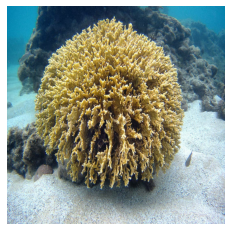

In [24]:
preds = model_funcion(np.expand_dims(imagem_correta, axis=0)) #Predição de uma única imagem
#soft_preds=tf.nn.softmax(preds).numpy().flatten()
decode_prof=decode(preds)
for list_prob in decode_prof[:3]:
    print('Classe: {} - Probabilidade: {:.6f}'.format(list_prob[0], list_prob[1]))
img=plt.imshow(imagem_correta/255)
plt.axis('off')
plt.show();

In [25]:
explainer_correta = lime_image.LimeImageExplainer()

In [26]:
%%time
explanation_correta = explainer_correta.explain_instance(imagem_correta.astype('double'), model_funcion, top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 14min 9s, sys: 54.2 s, total: 15min 4s
Wall time: 8min 26s


### Para a Classe mais provável

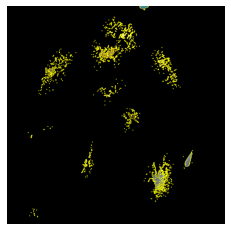

In [27]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[0], positive_only=True, num_features=20, hide_rest=True)
img=plt.imshow(mark_boundaries(temp /255, mask))
plt.axis('off')
plt.show();

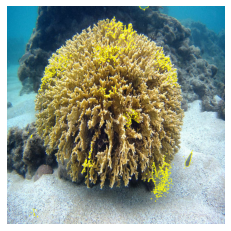

In [28]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[0], positive_only=True, num_features=20, hide_rest=False)
img=plt.imshow(mark_boundaries(temp /255, mask))
plt.axis('off')
plt.show();

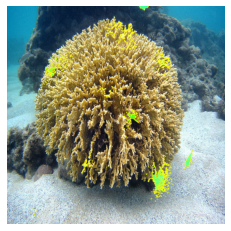

In [29]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
img=plt.imshow(mark_boundaries(temp /255, mask))
plt.axis('off')
plt.show();

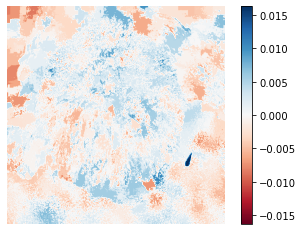

In [30]:
#Selecionar a classe mais provável
ind =  explanation_correta.top_labels[0]

#Mapeamento os pesos para cada explicação
dict_heatmap = dict(explanation_correta.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_correta.segments) 

#Plot
img=plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.axis('off')
plt.show();

### Para segunda classe mais provavel

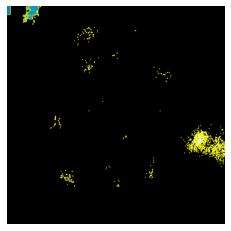

In [31]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[1], positive_only=True, num_features=20, hide_rest=True)
img=plt.imshow(mark_boundaries(temp /255, mask))
plt.axis('off')
plt.show();

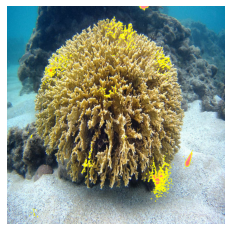

In [32]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[1], positive_only=False, num_features=20, hide_rest=False)
img=plt.imshow(mark_boundaries(temp /255, mask))
plt.axis('off')
plt.show();

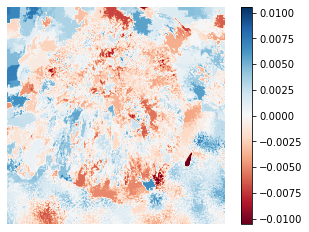

In [33]:
#Selecionar a classe mais provável
ind =  explanation_correta.top_labels[1]

#Mapeamento os pesos para cada explicação
dict_heatmap = dict(explanation_correta.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_correta.segments) 

#Plot
img=plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.axis('off')
plt.show();